In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace
import random
import scipy.optimize as optimize

# Assignment 2
This performance is brought to you by Ivar, Siri and Petter

## Task 2.1

In this task we have copied the code from assignment 1, and introduced $\gamma$

In [2]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model


def chooseDist(dist1,dist2,alpha): # Choose distribution given alpha to be probability of distribution 1.
    if(random.uniform(0,1)>=(1-alpha)):
        return dist1
    return dist2


def genNoise(alpha, N, mean, sigma, beta, magnitude, gamma, yreal): # Generate the noise of the signal
    e = np.zeros(N)
    for i in range(0,N):
        if (random.uniform(0,1) < gamma):
            e[i] = 100 - yreal[i]
        else:
            dist = chooseDist("Gauss","Laplace",alpha)
            if dist == "Laplace":
                #pdf = laplace_pdf
                pdf = laplace.pdf
                e[i] = magnitude * np.random.laplace(mean, beta)
            elif dist == "Gauss":
                #pdf = gauss_pdf
                pdf = norm.pdf
                e[i] = magnitude * np.random.normal(mean, sigma)
            else:
                raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")
    
    return e

## Task 2.2

Text(0.5, 1.0, 'Real model!!')

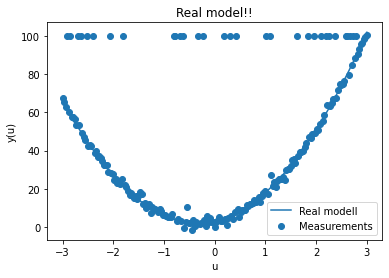

In [3]:
N = 201 # Number of measurements

u = np.linspace(-3,3,N) # "Measured" inputs.

# Define true modell
theta = [3,6,9] # Real parameters

ymod = arbitrary_poly(theta)


yreal = ymod(u) # Create the modell

# Values for measurements
alpha = 0

beta = 1

mean = 0

magnitude = 1

sigma = 1

gamma = 0.2

e = genNoise(alpha, N, mean, sigma, beta, magnitude, gamma, yreal)

y = yreal + e


# Plot
plt.figure()
plt.plot(u,yreal)
plt.scatter(u,y)
plt.legend(["Real modell","Measurements"])
plt.xlabel('u')
plt.ylabel('y(u)')
plt.title('Real model!!')

## Task 2.3

### Least squares

In [4]:
# LS function
def LS(degree, output, input):
    N = len(u)
    u_tensor_0 = np.reshape(u,(N,1))

    ones_vec = np.ones((N,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)
    
    for deg in range(2,degree + 1):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0,deg), axis=1)
    
    # (u^T * u)^-1
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u)
    
    # (u^T * y)
    u_transpose_dot_y = np.dot(u_tensor.T,y)
    
    # (u^T * u)^-1 * (u^T * y)
    est_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
    
    return est_params

Parameters linear:  [39.72787544  5.45998405]
Parameters quadratic:  [14.00360813  5.45998405  8.4898572 ]
Parameters cubic:  [14.00360813  6.58194788  8.4898572  -0.20572073]


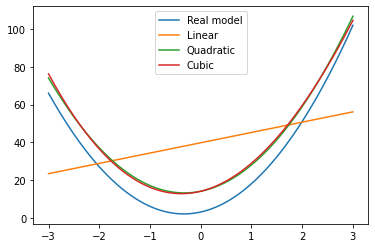

In [5]:
est_params_lin = LS(degree = 1,output = y,input = u)
est_params_quad = LS(degree = 2,output = y,input = u)
est_params_cub = LS(degree = 3,output = y,input = u)

print("Parameters linear: ", est_params_lin)
print("Parameters quadratic: ", est_params_quad)
print("Parameters cubic: ", est_params_cub)

# Creade estimated models
y_est_mod_lin = arbitrary_poly(est_params_lin.tolist())
y_est_mod_quad = arbitrary_poly(est_params_quad.tolist())
y_est_mod_cub = arbitrary_poly(est_params_cub.tolist())

y_est_lin = y_est_mod_lin(u)
y_est_quad = y_est_mod_quad(u)
y_est_cub = y_est_mod_cub(u)


# Plot 
plt.figure()
plt.plot(u,yreal)
plt.plot(u,y_est_lin)
plt.plot(u,y_est_quad)
plt.plot(u,y_est_cub)
plt.legend(['Real model','Linear','Quadratic','Cubic'])

### Maximum likelihood estimator
Instead of minimizing the error of a set of parameters, we now want to maximize the likelihood that a set of parameters is the right one. This is done by minimizing the negative log-likelihood function. That is, given $y = f(x) + e$, where e has the distribution $p$, we want to find
$$parameters = \arg\min_{params} -\log(p(y|f(x|params)))$$

In [6]:
def log_lik(param_vec,y,x):
    # This is the function we aim to minimize.
    
    # Param_vec contains the parameters + the standard diviation at the last place
    
    pdf = laplace.pdf # In this task, we only consider laplace distribution
    
    # If the standard deviation is negative, we assume the likelihood to be small. I.e. return a large number
    if param_vec[-1]<0:
        return (1e8)
    
    # The likelihood function values. I.e. the probability of getting y when in x with laplacian distribution and
    # standard deviation as given in param_vec[-1]
    
    lik = pdf(y,
             loc = sum([param*(x**i) for i, param in enumerate(param_vec[:-1])]),
             scale = param_vec[-1])
    
    # If lik consists of all zeros, the log-likelihood will be -infinity. Return a great value
    if all(v == 0 for v in lik):
        return(1e8)
    
    # Return the som of logarithm of the values of lik that are nonzero.
    return(-sum(np.log(lik[np.nonzero(lik)])))

In [7]:
# MLE function
def MLE(degree, input, output):
    N = len(output)
    init_params = np.zeros(degree + 2)
    
    init_params[-1] = N
    
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_params, 
                               # options = {'disp':True}, 
                                args = (output,input))
    MLE_params = opt_res.x[:-1]
    
    return MLE_params

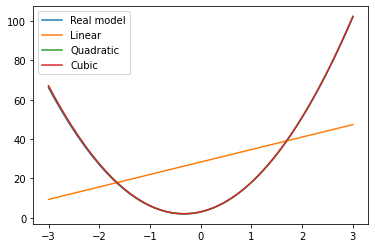

In [8]:
# Find the models for the three cases
MLE_params_lin = MLE(degree = 1, output = y, input = u)
MLE_params_quad = MLE(degree = 2, output = y, input = u)
MLE_params_cub = MLE(degree = 3, output = y, input = u)


MLE_est_mod_lin = arbitrary_poly(MLE_params_lin)
MLE_est_mod_quad = arbitrary_poly(MLE_params_quad)
MLE_est_mod_cub = arbitrary_poly(MLE_params_cub)

MLE_est_lin = MLE_est_mod_lin(u)
MLE_est_quad = MLE_est_mod_quad(u)
MLE_est_cub = MLE_est_mod_cub(u)

plt.figure()
plt.plot(u,yreal)
plt.plot(u,MLE_est_lin)
plt.plot(u,MLE_est_quad)
plt.plot(u,MLE_est_cub)
plt.legend(['Real model','Linear','Quadratic','Cubic'])

## Task 2.4 
Creating functions for model training (parameter estimation), model order selection and predictions of performance.

In this task, we chose to shufle our dataset, in order to obtain train, validation and test sets distributed over the whole timespan $[-3,3]$.

In [9]:
# Want to shuffle the dataset
indexes = np.arange(0,len(y))
random.shuffle(indexes)

# Split into three
index_train, index_val, index_test = np.split(indexes,3)

train_set = {'y':y[index_train],'u':u[index_train]}
val_set = {'y':y[index_val],'u':u[index_val]}
test_set = {'y':y[index_test],'u':u[index_test]}

In [10]:
# Train models:
def train(estimator_function, degree_list, train_input, train_output):
    # degree_list is a list of ints specifying which degrees to consider
    # input = model input, in this case u
    # output = model output, in this case y
    
    est_models = []
    est_params = []
    for deg in degree_list:
        params = estimator_function(degree = deg, input = train_input, output = train_output)
        est_params.append(params)
        
        mod = arbitrary_poly(params)
        est_models.append(mod)
    return est_models,est_params


# Choose model order

def choose_order(degree_list, est_models, val_input, val_output):
    # degree_list is a list of ints specifying which degrees to consider
    # input = model input, in this case u
    # output = model output, in this case y
    
    min_score = 1e8
    best_deg = 0
    best_mod  = ''
    for i,deg in enumerate(degree_list):
        #score = np.sqrt(np.mean((val_output - est_models[i](val_input))**2))
        score = sum(abs(val_output - est_models[i](val_input)))
        if score < min_score:
            min_score = score
            best_deg = deg
            best_mod = est_models[i]
            
    return best_deg, best_mod


def performance_index(model, test_input, test_output):
    # input = model input, in this case u
    # output = model output, in this case y
    return sum(abs(model(test_input) - test_output))

In [11]:
# Test for linear, quadratic and cubic model
deg_list = [1,2,3]

# MLE:
mods_mle,params_mle = train(MLE,deg_list, train_set['u'],train_set['y'])
deg_mle, mod_mle = choose_order(deg_list,mods_mle,val_set['u'],val_set['y'])
p_i_mle = performance_index(mod_mle,test_set['u'],test_set['y'])

# LS:
mods_ls,params_ls = train(LS,deg_list, train_set['u'],train_set['y'])
deg_ls, mod_ls = choose_order(deg_list,mods_ls,val_set['u'],val_set['y'])
p_i_ls = performance_index(mod_ls,test_set['u'],test_set['y'])

print("MLE:")
print("Chosen degree: ", deg_mle)
print("Performance index: ", p_i_mle)

print("LS:")
print("Chosen degree: ", deg_ls)
print("Performance index: ", p_i_ls)

MLE:
Chosen degree:  3
Performance index:  623.8874857680389
LS:
Chosen degree:  2
Performance index:  987.7095907313088


## Task 2.5
Plots of result from 2.4

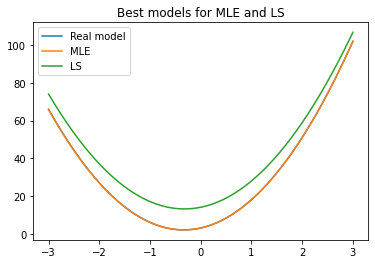

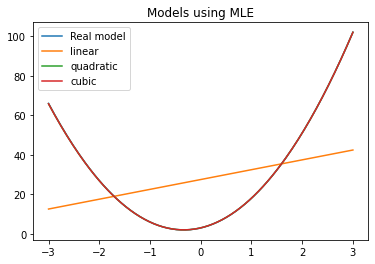

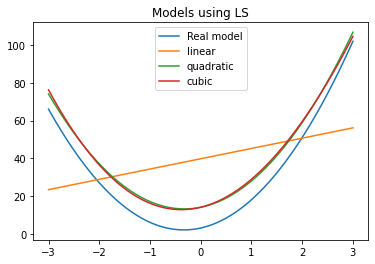

In [12]:
plt.figure()
plt.plot(u,yreal)
plt.plot(u,mod_mle(u))
plt.plot(u,mod_ls(u))
plt.legend(['Real model', 'MLE','LS'])
plt.title('Best models for MLE and LS')

plt.figure()
plt.plot(u,yreal)
plt.plot(u,mods_mle[0](u))
plt.plot(u,mods_mle[1](u))
plt.plot(u,mods_mle[2](u))
plt.title('Models using MLE')
plt.legend(['Real model', 'linear','quadratic','cubic'])

plt.figure()
plt.plot(u,yreal)
plt.plot(u,mods_ls[0](u))
plt.plot(u,mods_ls[1](u))
plt.plot(u,mods_ls[2](u))
plt.title('Models using LS')
plt.legend(['Real model', 'linear','quadratic','cubic'])

It is clear to see that MLE is best choice for this case. However, when $\gamma>0.5$, the likelihood is bigger that we have $y=100$ than the real value. In this case, the MLE will see the error value 100 as the most likely model, which renders the MLE useless. Even though LS does not perform well, it performes much better than MLE.

## Task 2.6
Estimated predictive performance for different values of $\gamma$.

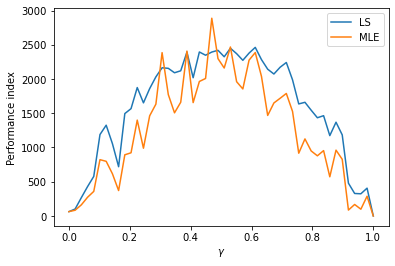

In [13]:

gamma_space = np.linspace(0,1)
performance_LS = np.zeros_like(gamma_space)
performance_MLE = np.zeros_like(gamma_space)

# Want to shuffle the dataset
indexes = np.arange(0,N)
random.shuffle(indexes)

# Split into three
index_train, index_val, index_test = np.split(indexes,3)

for i,gamma in enumerate(gamma_space):
    e = genNoise(alpha, N, mean, sigma, beta, magnitude, gamma, yreal)
    y = yreal + e
    
    # Extract data sets
    train_set = {'y':y[index_train],'u':u[index_train]}
    val_set = {'y':y[index_val],'u':u[index_val]}
    test_set = {'y':y[index_test],'u':u[index_test]}
    
    # MLE:
    mods_mle,params_mle = train(MLE,deg_list, train_set['u'],train_set['y'])
    deg_mle, mod_mle = choose_order(deg_list,mods_mle,val_set['u'],val_set['y'])
    p_i_mle = performance_index(mod_mle,test_set['u'],test_set['y'])
    
    performance_MLE[i] = p_i_mle

    # LS:
    mods_ls,params_ls = train(LS,deg_list, train_set['u'],train_set['y'])
    deg_ls, mod_ls = choose_order(deg_list,mods_ls,val_set['u'],val_set['y'])
    p_i_ls = performance_index(mod_ls,test_set['u'],test_set['y'])
    
    performance_LS[i] = p_i_ls
    

# Plot
plt.figure()
plt.plot(gamma_space,performance_LS)
plt.plot(gamma_space,performance_MLE)
plt.xlabel('$\gamma$')
plt.ylabel('Performance index')
plt.legend(['LS','MLE'])

We observe that both of the models have low values for $\gamma << 0.5$ and $\gamma>> 0.5$. However, we know that the output is much more like the true model for low gamma. That is, in comparrison with the output signal, the model performs better for high and low $\gamma$. In comparrison to the true model, they both perform better for low $\gamma$.

It is also visible that MLE has a better performance than LS for $\gamma>0.6$ and $\gamma < 0.4$, but that LS tends to be better for $0.4<\gamma<0.6$.

**a)** MLE

**b)** MLE